# Bias@ECIR23 plots

This notebook contains the code to generate the charts included in the paper "Understanding Search Behavior Bias in Wikipedia" - Bruno Scarone; Ricardo Baeza-Yates; Erik Bernhardson published at Bias@ECIR23.

In [1]:
import os, sys
import re, math
# from user_agents import parse # from https://pypi.org/project/user-agents/
import time
from itertools import groupby 

import findspark
findspark.init('/usr/lib/spark3')
# findspark.init('')
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T, Window
import wmfdata.spark as wmfspark

# defining the spark session
spark_config = {}
spark = wmfspark.create_session(
    app_name='Pyspark notebook - bias@ecir23 plots | bscarone (WMF)', 
    type='regular',
    extra_settings=spark_config,
    # ship_python_env=True
)

SPARK_HOME: /usr/lib/spark3
Using Hadoop client lib jars at 3.2.0, provided by Spark.
PYSPARK_PYTHON=/opt/conda-analytics/bin/python3


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/02 23:20:55 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
23/03/02 23:20:56 WARN Utils: Service 'sparkDriver' could not bind on port 12000. Attempting port 12001.
23/03/02 23:20:56 WARN Utils: Service 'sparkDriver' could not bind on port 12001. Attempting port 12002.
23/03/02 23:20:56 WARN Utils: Service 'sparkDriver' could not bind on port 12002. Attempting port 12003.
23/03/02 23:20:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/03/02 23:20:57 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/03/02 23:20:57 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
23/03/02 23:20:57 WARN Utils: Service 'SparkUI' could not bin

In [2]:
print('PySpark Version :'+spark.version)

PySpark Version :3.1.2


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Dwell times histogram (Fig. 1)

### Load data

In [127]:
# file to be loaded is located at /user/bscarone/dwell-time/df_clicks_distr_4-1072022_r182022.parquet
df_dw = spark.read.parquet('dwell-time/df_sessionid_amethod_nonempty_dwelltimes_4-1072022_r182022.parquet')

### Plot chart

In [165]:
# code adapted from file "dwell_time_by_amethod.ipynb" to test alternative printing options
def plot_dwell_times_discovery_by_amethod(df_dw, bins, timerange, day, month, year, is_filtered):
        
    df_desk = df_dw.where(F.col("access_method")=="desktop").select("dwell_times")
    df_mb = df_dw.where(F.col("access_method")=="mobile web").select("dwell_times")
    # df_amethod.show()
    bins = list(range(bins))
    bins[-1] = bins[-1]-0.01 # last interval is not half-closed, so it generates a spike otherwise
    
    df_desk_dw_ne_total = df_desk.withColumn("dwell_times", F.explode("dwell_times")).toPandas()
    df_mb_dw_ne_total = df_mb.withColumn("dwell_times", F.explode("dwell_times")).toPandas()
    
    n_desk = df_desk_dw_ne_total.shape[0]
    print(f'''Total dwell times - desktop''',n_desk)
    try:
        ws_desk = [(1/n_desk)*100]*n_desk
    except:
        ws_desk = None
        
    n_mb = df_mb_dw_ne_total.shape[0]
    print(f'''Total dwell times - mobile web''',n_mb)
    try:
        ws_mb = [(1/n_mb)*100]*n_mb
    except:
        ws_mb = None
        
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    df_desk_dw_ne_total.hist(column="dwell_times",bins=bins,range=timerange,weights=ws_desk,grid=False,color="royalblue",alpha=.9, ax=ax[0])
    df_mb_dw_ne_total.hist(column="dwell_times",bins=bins,range=timerange,weights=ws_mb,grid=False,color="royalblue",alpha=.9, ax=ax[1])

    # plt.title("Dwell time (discovery.query_clicks_daily) - {} on {}-{}/{}/{}".format(access_method,day,day+6,month,year), fontsize = 18)
    ax[0].grid(linestyle='--', linewidth=.8) # lightgray color='gainsboro'
    ax[1].grid(linestyle='--', linewidth=.8)
    # ax[0,0].set_axisbelow(True)
    plt.title("")
    for i in range(len(ax)):
        ax[i].set_title("")
        ax[i].set_xlabel("Dwell time (in seconds)", fontsize=16)
        ax[i].tick_params(axis="x", labelsize=14)
        ax[i].set_ylabel("% of total", fontsize=16)
        ax[i].tick_params(axis="y", labelsize=14)
        ax[i].set_ylim([0,1.9])
    
    if is_filtered:
        plt.savefig(f'/home/bscarone/search-metrics/results/bias@ecir23/outputs/dwell_times_all_{day}-{day+6}{month}{year}_{timerange[0]}-{timerange[1]}_filtered_v2.png')
    else:
        plt.savefig(f'/home/bscarone/search-metrics/results/bias@ecir23/outputs/dwell_times_all_{day}-{day+6}{month}{year}_{timerange[0]}-{timerange[1]}_v2.png')


Total dwell times - desktop 719425
Total dwell times - mobile web 743539


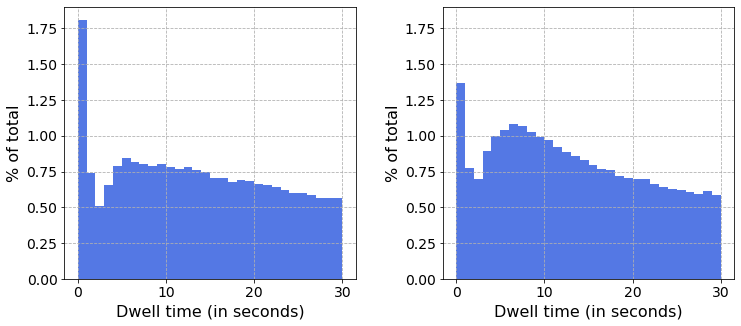

In [166]:
plot_dwell_times_discovery_by_amethod(df_dw, 31, (0,30), 4, 7, 2022, False)

Example to evaluate the use of percentages % or fractions

In [ ]:
df_ex = pd.DataFrame({
    'length': [1.5, 0.5, 1.2, 0.9, 3],
    'width': [0.7, 0.2, 0.15, 0.2, 1.1]
    }, index=['pig', 'rabbit', 'duck', 'chicken', 'horse'])
n = df_ex.shape[0]
ws_ex = [1/n*100]*n
hist = df_ex.hist(bins=3,weights=ws_ex)

## Average page length per dwell time bin (subrange [0s, 600s]) (Fig. 2)

### Load & preprocess data

In [38]:
# data is located at user/bscarone/dwell-time/df_sessionid_amethod_dwelltime_pagelen_4-1072022_r1182022.parquet
output_df_r = spark.read.parquet('dwell-time/df_sessionid_amethod_dwelltime_pagelen_4-1072022_r1182022.parquet')

In [40]:
# using https://github.com/ipython/ipynb
from ipynb.fs.defs.dwell_time_avg_pagelen_by_amethod import get_avg_pagelen_per_dwelltime_bin, get_mean_pagelen

#### Desktop

In [39]:
bin_avglen_desk_600 = get_avg_pagelen_per_dwelltime_bin(output_df_r, "desktop", 600)

ipynb.fs.defs.dwell_time_avg_pagelen_by_amethod:177: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


bins_idx [5, 103, 158, 21, 51, 62, 6, 82, 15, 25, 518, 353, 13, 102, 302, 128, 76, 77, 411, 264, 210, 22, 139, 41, 59, 366, 204, 42, 550, 73, 111, 2, 53, 99, 87, 166, 14, 118, 114, 532, 119, 177, 326, 313, 67, 569, 176, 503, 180, 11, 566, 430, 24, 441, 155, 90, 34, 107, 43, 106, 27, 47, 69, 32, 71, 116, 65, 40, 570, 476, 381, 312, 231, 495, 310, 45, 375, 513, 153, 8, 560, 371, 184, 63, 4, 37, 439, 186, 167, 452, 74, 1, 192, 359, 16, 488, 35, 222, 105, 68, 95, 81, 151, 154, 146, 122, 175, 70, 28, 504, 361, 402, 170, 55, 52, 31, 113, 197, 85, 123, 9, 322, 427, 46, 410, 491, 223, 356, 130, 267, 57, 20, 595, 19, 91, 216, 277, 86, 157, 311, 10, 30, 125, 96, 329, 179, 18, 168, 164, 145, 251, 60, 250, 543, 183, 132, 284, 209, 49, 206, 23, 321, 100, 17, 559, 75, 228, 432, 36, 112, 497, 584, 101, 241, 33, 299, 129, 12, 272, 156, 182, 247, 29, 79, 7, 455, 260, 398, 448, 93, 338, 215, 342, 261, 189, 318, 3, 328, 172, 50, 235, 44, 64, 191, 188, 48, 38, 72, 483, 109, 576, 449, 382, 174, 217, 308, 8

In [41]:
mean_desk = get_mean_pagelen(output_df_r, "desktop")

#### Mobile web

In [90]:
bin_avglen_mw_600 = get_avg_pagelen_per_dwelltime_bin(output_df_r, "mobile web", 600)

ipynb.fs.defs.dwell_time_avg_pagelen_by_amethod:177: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


bins_idx [302, 92, 185, 121, 91, 153, 36, 72, 90, 80, 48, 2, 97, 159, 83, 95, 89, 21, 6, 172, 182, 10, 23, 11, 206, 176, 53, 81, 32, 192, 262, 93, 39, 24, 66, 1, 184, 62, 4, 31, 123, 326, 486, 129, 274, 60, 458, 27, 190, 28, 152, 257, 25, 12, 234, 40, 98, 239, 536, 57, 464, 38, 8, 79, 166, 198, 67, 298, 76, 438, 37, 86, 46, 120, 598, 5, 246, 115, 16, 494, 160, 433, 103, 288, 276, 320, 209, 259, 213, 293, 416, 430, 544, 329, 47, 3, 29, 68, 114, 241, 69, 127, 84, 44, 96, 361, 94, 226, 140, 181, 444, 19, 203, 22, 191, 105, 14, 576, 64, 235, 128, 147, 45, 132, 221, 70, 18, 77, 9, 456, 13, 403, 305, 104, 323, 272, 357, 247, 110, 353, 196, 35, 180, 306, 304, 43, 33, 87, 174, 15, 78, 287, 463, 245, 200, 130, 75, 451, 227, 457, 401, 82, 134, 106, 381, 177, 146, 346, 202, 268, 238, 151, 144, 173, 51, 179, 393, 188, 400, 418, 380, 195, 454, 294, 113, 155, 135, 365, 386, 248, 309, 125, 17, 7, 373, 56, 440, 422, 30, 350, 133, 137, 423, 52, 482, 164, 88, 20, 71, 187, 145, 141, 49, 220, 54, 526, 171

In [91]:
mean_mw = get_mean_pagelen(output_df_r, "mobile web")

### Plot charts

In [325]:
def plot_avg_pagelen_per_dwelltime_bin_largernrofbins(bin_avglen, nr_bins, mean, year, month, day, access_method):
    lists = sorted(bin_avglen.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.figure(figsize=(15,4))
    plt.plot(x, y, color='royalblue', marker='')
    # for (x0,y0) in lists:
    #     plt.vlines(x=x0, ymin=0, ymax=y0, color='grey')
    # plt.stem(x, y, linefmt='grey', use_line_collection = False)
    # this is the mean of the plotted points, I prefer to use the mean of all points
    # which has to be passed as a parameter
    # mean = np.mean(list(bin_avglen.values())) 
    plt.grid(linestyle='--', linewidth=1.5, color='gainsboro')
    plt.axhline(y=mean, color='r', linestyle='-', label = f'Mean of page lengths (complete {access_method} dataset)')
    plt.legend(fontsize=13,loc="lower right")
    plt.ylim(ymin=0,ymax=68000)
    # plt.xlim(xmin=-1)
    plt.title("")
    # plt.title(f'''Avg. page length per dwell time bin - {access_method} on {day}-{day+6}/{month}/{year}''', fontsize=18)
    plt.xlabel("Bin index", fontsize=16)
    plt.xticks(fontsize=14)
    # plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize=14)
    plt.ylabel("Avg. page length (in Bytes)", fontsize=16)
    plt.yticks(fontsize=14)
    plt.savefig(f'/home/bscarone/search-metrics/results/bias@ecir23/outputs/avg_pagelen_dwelltime_{nr_bins}bins(large)_{access_method}_{day}-{day+6}{month}{year}.png',bbox_inches = 'tight')

    plt.show()
    return

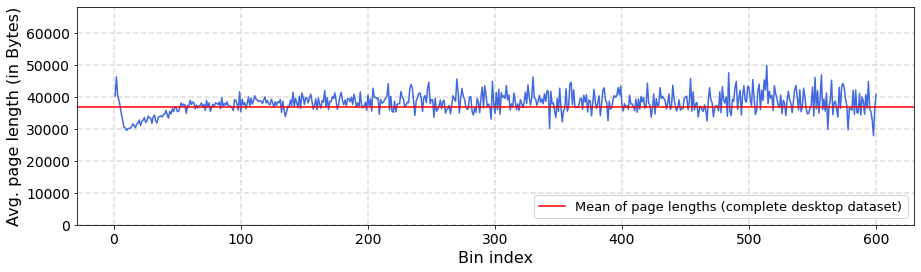

In [326]:
plot_avg_pagelen_per_dwelltime_bin_largernrofbins(bin_avglen_desk_600,600,mean_desk,2022,7,4,"desktop")

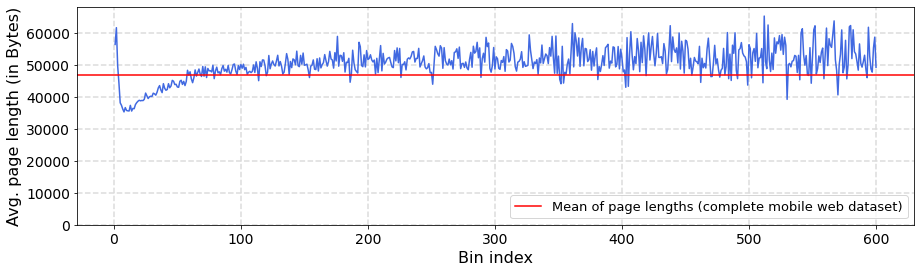

[Stage 91:====>            (4 + 1) / 15][Stage 92:====>            (4 + 1) / 15]

In [327]:
plot_avg_pagelen_per_dwelltime_bin_largernrofbins(bin_avglen_mw_600,600,mean_mw,2022,7,4,"mobile web")

## Dwell time vs Page length - linear scale (Fig. 3)

### Load data

In [107]:
# file is located at /user/bscarone/dwell-time/df_sessionid_amethod_dwelltime_pagelen_sessionlen_4-10102022_r18102022.parquet
df_dw_vs_pagelen =  spark.read.parquet('dwell-time/df_sessionid_amethod_dwelltime_pagelen_sessionlen_4-10102022_r18102022.parquet')

### Pearson correlations and p-vals

In [18]:
def pearson_corr_scipy(df,x_col,y_col):
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
    pddf = df.toPandas()
    pcc = stats.pearsonr(pddf[x_col],pddf[y_col])
    print(f'''Pearson Correlation Coefficient between {x_col} and {y_col} is {pcc[0]} (p-val={pcc[1]}).''')

In [203]:
from ipynb.fs.defs.dwell_time_sessionlen_pagelen_by_amethod import pearson_corr

In [204]:
# all
pearson_corr(df_dw_vs_pagelen,'dwell_time','revision_text_bytes')

[Stage 84:==============================================>           (4 + 1) / 5]

Pearson Correlation Coefficient between dwell_time and revision_text_bytes is 0.02865157375368939.


In [211]:
# all 
pearson_corr_scipy(df_dw_vs_pagelen,'dwell_time','revision_text_bytes')

Pearson Correlation Coefficient between dwell_time and revision_text_bytes is 0.0286515737536889 (p-val=2.533473389183762e-289).


In [212]:
df_dw_vs_pagelen_desk = df_dw_vs_pagelen.select(F.col('dwell_time'),F.col('revision_text_bytes')).where(F.col("access_method")=='desktop')

In [214]:
pearson_corr_scipy(df_dw_vs_pagelen_desk,'dwell_time','revision_text_bytes')

Pearson Correlation Coefficient between dwell_time and revision_text_bytes is 0.023326374269997327 (p-val=4.1501467030229484e-94).


In [215]:
df_dw_vs_pagelen_mw = df_dw_vs_pagelen.select(F.col('dwell_time'),F.col('revision_text_bytes')).where(F.col("access_method")=='mobile web')

In [216]:
pearson_corr_scipy(df_dw_vs_pagelen_mw,'dwell_time','revision_text_bytes')

Pearson Correlation Coefficient between dwell_time and revision_text_bytes is 0.03568899194964634 (p-val=2.8229099270186043e-232).


### Plot charts

In [123]:
def plot_scatterplot_by_amethod(df,x_var,y_var,x_label,y_label,x_unit,y_unit,access_method,year,month,day_start,day_end,alpha,figsize,use_log,zoomed):
    if access_method != "all":
        df = df.select(F.col(x_var),F.col(y_var)).where(F.col("access_method")==access_method)
    df.toPandas().plot.scatter(x=x_var, y=y_var, color='royalblue', alpha=alpha, figsize=figsize, loglog=use_log)
    # format plot
    # plt.title(f'''{x_label} vs {y_label} - {access_method} on {day_start}-{day_end}/{month}/{year} - loglog={use_log}''', fontsize=16) # took +6 out
    plt.grid(linestyle='--', linewidth=1.5, color='gainsboro')
    plt.title("")
    plt.ylabel(f'''{x_label} (in {x_unit})''', fontsize=16) # adjust units
    plt.yticks(fontsize=14)
    plt.xlabel(f'''{y_label} (in {y_unit})''', fontsize=16) # adjust units
    plt.xticks(fontsize=14)
    if not use_log:
        plt.ylim(ymin=0)
        plt.xlim(xmin=0)
    
    # save plot
    filepath = f'/home/bscarone/search-metrics/results/bias@ecir23/outputs/scatterplot_{x_var}_{y_var}_{access_method}_{day_start}-{day_end}{month}{year}'
    if use_log:
        filepath = filepath + "_loglog"
    if zoomed:
        filepath = filepath + "_zoomed"
    filepath = filepath + ".png"
    plt.savefig(filepath)

In [124]:
plot_scatterplot_by_amethod(df_dw_vs_pagelen,'dwell_time','revision_text_bytes','Dwell time','Page length',
                            'seconds','bytes','desktop',2022,10,4,10,0.3,(8, 8),False,False)

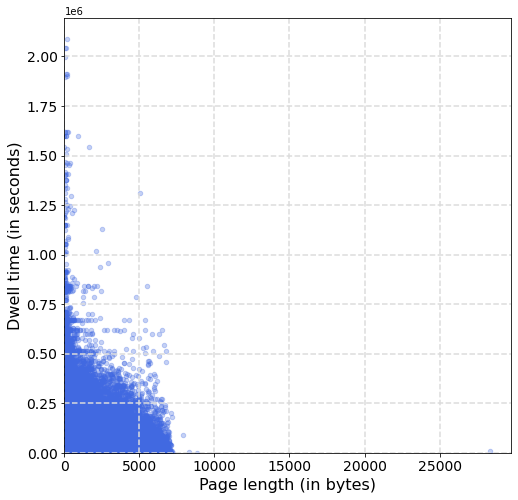

In [125]:
plot_scatterplot_by_amethod(df_dw_vs_pagelen,'dwell_time','revision_text_bytes','Dwell time','Page length',
                            'seconds','bytes','mobile web',2022,10,4,10,0.3,(8, 8),False,False)

## Avg. rank clicked on vs TTFC (Fig. 4)

### Load data

In [4]:
# file is located at clicks-rank/df_sessionid_hits_clicks_access_method_timestamp_click_positions_searchavgrank_searchttfc_...
df_avgrank_ttfc_amethod = spark.read.parquet('clicks-rank/df_sessionid_hits_clicks_access_method_timestamp_click_positions_searchavgrank_searchttfc_4-10102022_r20102022.parquet')

In [15]:
df_avgrank_ttfc_amethod.printSchema()

root
 |-- session_id: string (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- title: string (nullable = true)
 |    |    |-- index: string (nullable = true)
 |    |    |-- pageid: integer (nullable = true)
 |    |    |-- score: float (nullable = true)
 |    |    |-- profilename: string (nullable = true)
 |-- clicks: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- pageid: integer (nullable = true)
 |    |    |-- timestamp: long (nullable = true)
 |    |    |-- referer: string (nullable = true)
 |-- access_method: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- click_positions: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- click_positions_filtered: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- ttfc: integer (nullable = true)



In [36]:
df_avgrank_ttfc_amethod_gbysession = spark.read.parquet('clicks-rank/df_sessionid_access_method__timestamp_click_positions_sessionavgrank_sessionavgttfc_4-10102022_r20102022.parquet')

In [37]:
df_avgrank_ttfc_amethod_gbysession.printSchema()

root
 |-- session_id: string (nullable = true)
 |-- access_method: string (nullable = true)
 |-- avg_rank_session: double (nullable = true)
 |-- avg_ttfc_session: double (nullable = true)



#### Fix `click_positions_filtered` col - random behavior on some entries

In the dataset used to compute the charts that show Avg. rank clicked on vs TTFC (Fig. 4 of the paper), the click positions in the ranking were calculated (`click_positions` column) and then the 0-entries were filtered (which account for the value not being in the ranking) using the simple UDF `FilterRank0`.
The resulting column with the filtered version (`click_positions_filtered`) contained some incorrect entries, like [11, 11, 11] -> [] or [2]->[]. The issue may be realted to some concurrency happening when concatenating the generation of new columns (`.withColumn(...)`). To fix it, the filtering was recomputed.

In [5]:
# click_positions_filtered has wrong results
# first, delete avg_rank which was computed based on click_positions_filtered
df_avgrank_ttfc_amethod = df_avgrank_ttfc_amethod.drop('avg_rank')

In [6]:
# udf used to (correctly) compute the filtering
@F.udf(returnType=T.ArrayType(T.IntegerType()))
def FilterRank0(click_positions):
    # eliminate entries that have value 0 
    return list(filter((lambda x : x != 0),click_positions))

In [7]:
# recompute click_positions_filtered as click_positions_filtered2
# ..._val = "validated"
df_avgrank_ttfc_amethod_val = df_avgrank_ttfc_amethod\
            .withColumn('click_positions_filtered2', FilterRank0(F.col('click_positions')))

In [8]:
# filter entries where click_positions_filtered2 == [] (they would generate avg_rank == null)
df_avgrank_ttfc_amethod_val_f = df_avgrank_ttfc_amethod_val.select("*").where(F.size(F.col('click_positions_filtered2'))>0)

In [9]:
# recompute avg_rank as before based on click_positions_filtered2
df_avgrank_ttfc_amethod_val_f = df_avgrank_ttfc_amethod_val_f\
            .withColumn('sum_rank', F.expr('aggregate(click_positions_filtered2, cast(0 as float), (acc, val) -> acc + cast(val as float))'))

In [10]:
df_avgrank_ttfc_amethod_val_f = df_avgrank_ttfc_amethod_val_f\
            .withColumn('avg_rank',
                F.col('sum_rank') / F.size(F.col('click_positions_filtered2'))
            )#.drop('sum_rank')

In [11]:
# check there are no null entries in avg_rank
from pyspark.sql.functions import col,isnan, when, count
df_avgrank_ttfc_amethod_val_f.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ["avg_rank"]]).show()

+--------+
|avg_rank|
+--------+
|       0|
+--------+



In [14]:
# df_avgrank_ttfc_amethod_val_f.select("clicks","click_positions","click_positions_filtered","click_positions_filtered2",'sum_rank','avg_rank').show()

In [13]:
# to see cases that were mistakenly computed before
df_avgrank_ttfc_amethod_val_f.select("click_positions","click_positions_filtered",'click_positions_filtered2','sum_rank','avg_rank')\
    .where(F.size(F.col("click_positions"))!=F.size(F.col("click_positions_filtered"))).show(20)

+---------------+------------------------+-------------------------+--------+--------+
|click_positions|click_positions_filtered|click_positions_filtered2|sum_rank|avg_rank|
+---------------+------------------------+-------------------------+--------+--------+
|         [1, 0]|                     [1]|                      [1]|     1.0|     1.0|
|         [0, 5]|                     [5]|                      [5]|     5.0|     5.0|
|            [2]|                      []|                      [2]|     2.0|     2.0|
|            [1]|                      []|                      [1]|     1.0|     1.0|
|         [0, 1]|                     [1]|                      [1]|     1.0|     1.0|
|         [5, 5]|                     [5]|                   [5, 5]|    10.0|     5.0|
|         [1, 1]|                     [1]|                   [1, 1]|     2.0|     1.0|
|            [1]|                      []|                      [1]|     1.0|     1.0|
|            [1]|                      []| 

#### Fix results gruped by session - session-level

In [38]:
# recompute based on corrected dataset avg accross all searches from a session
df_avgrank_ttfc_amethod_val_f_gbysession = df_avgrank_ttfc_amethod_val_f.groupBy("session_id","access_method")\
                        .agg(F.mean("avg_rank").alias("avg_rank_session"),F.mean("ttfc").alias("avg_ttfc_session"))

In [39]:
df_avgrank_ttfc_amethod_val_f_gbysession.printSchema()

root
 |-- session_id: string (nullable = true)
 |-- access_method: string (nullable = true)
 |-- avg_rank_session: double (nullable = true)
 |-- avg_ttfc_session: double (nullable = true)



### Pearson correlations and p-vals

#### Search-level

In [16]:
df_only_avgrank_ttfc_amethod = df_avgrank_ttfc_amethod_val_f.select("avg_rank","ttfc","access_method")

In [25]:
df_only_avgrank_ttfc_amethod_desk = df_only_avgrank_ttfc_amethod.select("avg_rank","ttfc","access_method").where(F.col("access_method")=="desktop")

In [27]:
df_only_avgrank_ttfc_amethod_mw = df_only_avgrank_ttfc_amethod.select("avg_rank","ttfc","access_method").where(F.col("access_method")=="mobile web")

In [23]:
# all
pearson_corr_scipy(df_only_avgrank_ttfc_amethod,"avg_rank","ttfc")

Pearson Correlation Coefficient between avg_rank and ttfc is 0.08145878066986655 (p-val=0.0).


In [26]:
# desktop
pearson_corr_scipy(df_only_avgrank_ttfc_amethod_desk,"avg_rank","ttfc")

Pearson Correlation Coefficient between avg_rank and ttfc is 0.07888035464810875 (p-val=0.0).


In [28]:
# mobile web
pearson_corr_scipy(df_only_avgrank_ttfc_amethod_mw,"avg_rank","ttfc")

Pearson Correlation Coefficient between avg_rank and ttfc is 0.09033115120109773 (p-val=0.0).


#### Session-level

In [41]:
df_avgrank_ttfc_amethod_val_f_gbysession_desk = df_avgrank_ttfc_amethod_val_f_gbysession.select("*").where(F.col("access_method")=="desktop")

In [42]:
df_avgrank_ttfc_amethod_val_f_gbysession_mw = df_avgrank_ttfc_amethod_val_f_gbysession.select("*").where(F.col("access_method")=="mobile web")

In [40]:
# all
pearson_corr_scipy(df_avgrank_ttfc_amethod_val_f_gbysession,"avg_rank_session","avg_ttfc_session")

Pearson Correlation Coefficient between avg_rank_session and avg_ttfc_session is 0.09082453738598535 (p-val=0.0).


In [43]:
# desktop
pearson_corr_scipy(df_avgrank_ttfc_amethod_val_f_gbysession_desk,"avg_rank_session","avg_ttfc_session")

Pearson Correlation Coefficient between avg_rank_session and avg_ttfc_session is 0.08393413834016973 (p-val=0.0).


In [44]:
# mobile web
pearson_corr_scipy(df_avgrank_ttfc_amethod_val_f_gbysession_mw,"avg_rank_session","avg_ttfc_session")

Pearson Correlation Coefficient between avg_rank_session and avg_ttfc_session is 0.10519134268512137 (p-val=0.0).


### Plot charts

In [31]:
def plot_scatterplot_by_amethod(df,x_var,y_var,x_label,y_label,x_unit,y_unit,access_method,year,month,day_start,day_end,alpha,figsize,use_log,zoomed):
    if access_method != "all":
        df = df.select(F.col(x_var),F.col(y_var)).where(F.col("access_method")==access_method)
    df.toPandas().plot.scatter(x=x_var, y=y_var, color='royalblue', alpha=alpha, figsize=figsize, loglog=use_log, zorder=1)
    # format plot
    # plt.title(f'''{x_label} vs {y_label} - {access_method} on {day_start}-{day_end}/{month}/{year} - loglog={use_log}''', fontsize=16) # took +6 out
    plt.title("")
    plt.grid(axis='y', linestyle='--', linewidth=1.5, color='gainsboro', zorder=0)
    ax = plt.gca()
    ax.set_axisbelow(True)
    if x_unit == "":
        plt.xlabel(f'''{x_label}''', fontsize=16) # adjust units
    else:
        plt.xlabel(f'''{x_label} (in {x_unit})''', fontsize=16) # adjust units
    if y_unit == "":
        plt.ylabel(f'''{y_label}''', fontsize=16) # adjust units
    else:
        plt.ylabel(f'''{y_label} (in {y_unit})''', fontsize=16) # adjust units
    if not use_log:
        plt.ylim(ymin=0)
        plt.xlim(xmin=0)
        plt.xticks(np.arange(0, 21+1, 1.0), fontsize=14) # paramterize according to values of df_avgrank_ttfc_amethod.avg_rank
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # save plot
    filepath = f'/home/bscarone/search-metrics/results/bias@ecir23/outputs/scatterplot_{x_var}_{y_var}_{access_method}_{day_start}-{day_end}{month}{year}'
    if use_log:
        filepath = filepath + "_loglog"
    if zoomed:
        filepath = filepath + "_zoomed"
    filepath = filepath + ".png"
    plt.savefig(filepath, bbox_inches = 'tight')

#### Search level

In [29]:
# version using the dataset with errors
# plot_scatterplot_by_amethod(df_avgrank_ttfc_amethod_f,"avg_rank","ttfc","Avg. rank clicked on (search-level)",
#                             "TTFC (search-level)","seconds","","desktop",2022,10,4,10,0.3,(12,6),False,False)

In [35]:
# corrected dataset
plot_scatterplot_by_amethod(df_avgrank_ttfc_amethod_val_f,"avg_rank","ttfc","Avg. rank clicked on (search-level)",
                            "TTFC (search-level)","seconds","","desktop",2022,10,4,10,0.3,(12,6),False,False)

/home/bscarone/.conda/envs/2023-03-02T18.27.04_bscarone/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


In [33]:
# version using the dataset with errors
# plot_scatterplot_by_amethod(df_avgrank_ttfc_amethod_f,"avg_rank","ttfc","Avg. rank clicked on (search-level)",
#                             "TTFC (search-level)","seconds","","mobile web",2022,10,4,10,0.3,(12,6),False,False)

/home/bscarone/.conda/envs/2023-03-02T18.27.04_bscarone/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


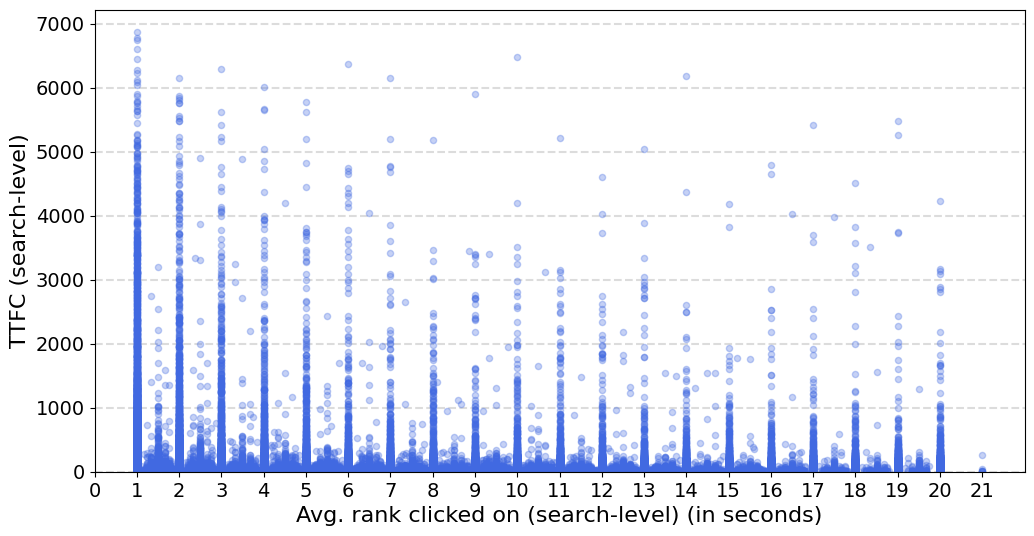

In [34]:
plot_scatterplot_by_amethod(df_avgrank_ttfc_amethod_val_f,"avg_rank","ttfc","Avg. rank clicked on (search-level)",
                            "TTFC (search-level)","seconds","","mobile web",2022,10,4,10,0.3,(12,6),False,False)

#### Session level

In [45]:
# version using the dataset with errors
# plot_scatterplot_by_amethod(df_avgrank_ttfc_amethod_gbysession,"avg_rank_session","avg_ttfc_session",
#                             "Avg. rank clicked on (session-level)","TTFC (session-level)","seconds","",
#                             "desktop",2022,10,4,10,0.3,(12,6),False,False)

/home/bscarone/.conda/envs/2023-03-02T18.27.04_bscarone/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


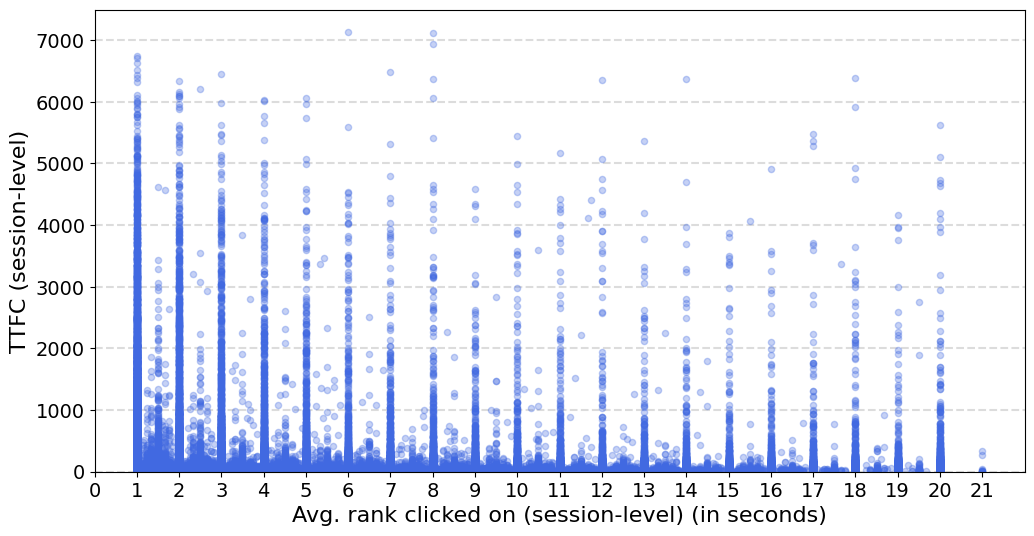

In [46]:
plot_scatterplot_by_amethod(df_avgrank_ttfc_amethod_val_f_gbysession,"avg_rank_session","avg_ttfc_session",
                            "Avg. rank clicked on (session-level)","TTFC (session-level)","seconds","",
                            "desktop",2022,10,4,10,0.3,(12,6),False,False)

In [ ]:
# version using the dataset with errors
# plot_scatterplot_by_amethod(df_avgrank_ttfc_amethod_gbysession,"avg_rank_session","avg_ttfc_session",
#                             "Avg. rank clicked on (session-level)","TTFC (session-level)","seconds","",
#                             "mobile web",2022,10,4,10,0.3,(12,6),False,False)

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)
/home/bscarone/.conda/envs/2023-03-02T18.27.04_bscarone/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


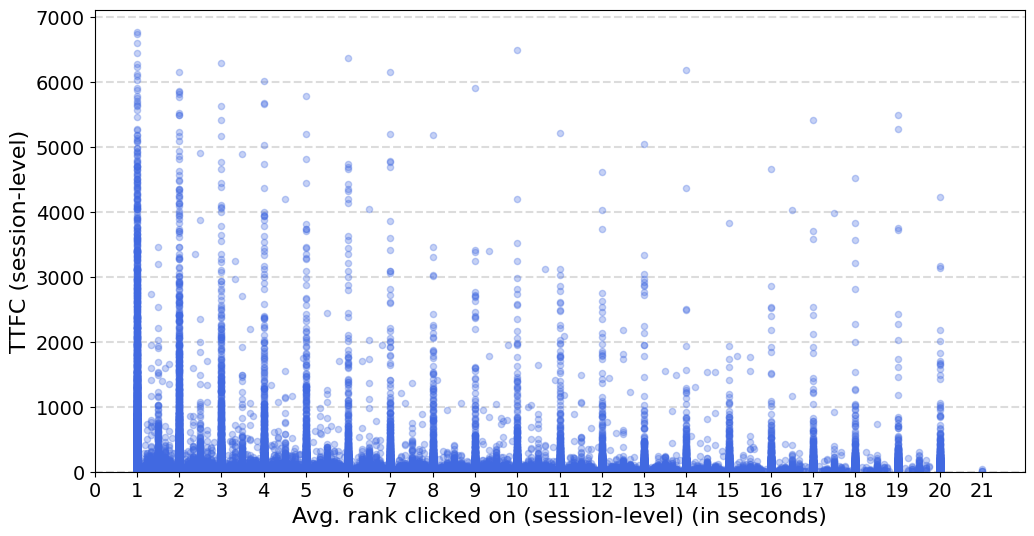

In [48]:
plot_scatterplot_by_amethod(df_avgrank_ttfc_amethod_val_f_gbysession,"avg_rank_session","avg_ttfc_session",
                            "Avg. rank clicked on (session-level)","TTFC (session-level)","seconds","",
                            "mobile web",2022,10,4,10,0.3,(12,6),False,False)